In [ ]:
!pip install ray
!pip install tensorflow
!pip install keras-tuner

In [ ]:
import ray
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras_tuner import HyperModel, RandomSearch
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
ray.init()  # Initialize Ray for parallel processing

2024-11-20 13:19:44,361	INFO worker.py:1819 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.39.0


In [ ]:
# Load the Breast Cancer dataset
data = load_breast_cancer()

In [ ]:
# Create a DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # Add the target column

In [ ]:
# Display the first few rows of the DataFrame
df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
df.shape

(569, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
df['target'].value_counts()

,count
target,
1,357
0,212


In [ ]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define a HyperModel for neural architecture search
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Add hidden layers dynamically based on hyperparameters
        for i in range(hp.Int("num_layers", 1, 5)):  # 1 to 5 layers
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation=hp.Choice("activation", ["relu", "tanh"])
                )
            )
            if hp.Boolean("dropout"):
                model.add(layers.Dropout(rate=hp.Float("dropout_rate", 0.2, 0.5)))

        # Add output layer
        model.add(layers.Dense(1, activation="sigmoid"))

        # Compile the model
        model.compile(
            optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        return model

In [ ]:
# Function to perform hyperparameter tuning in parallel
@ray.remote
def perform_tuning(search_id):
    print(f"Search Space {search_id}: Starting tuning...")
    hypermodel = MyHyperModel()
    tuner = RandomSearch(
        hypermodel,
        objective="val_accuracy",
        max_trials=10,
        executions_per_trial=1,
        directory=f"tuning_dir_{search_id}",
        project_name="parallel_nas",
    )
    tuner.search(X_train, y_train, validation_split=0.2, epochs=20, verbose=0)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(
        X_train, y_train, validation_split=0.2, epochs=20, verbose=0
    )
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    return {
        "search_id": search_id,
        "test_accuracy": test_accuracy,
        "best_hyperparameters": best_hps.values,
        "history": history.history,
    }

# Launch parallel hyperparameter tuning
num_searches = 5
results = ray.get([perform_tuning.remote(i) for i in range(num_searches)])

# Display results for all trials
print("\nResults for all searches:")
for result in results:
    print(f"\nSearch ID: {result['search_id']}")
    print(f"Test Accuracy: {result['test_accuracy']}")
    print("Best Hyperparameters:")
    for key, value in result["best_hyperparameters"].items():
        print(f"  {key}: {value}")

(perform_tuning pid=24370) Search Space 1: Starting tuning...
(perform_tuning pid=24370) Reloading Tuner from tuning_dir_1/parallel_nas/tuner0.json


(pid=24371) 2024-11-20 13:29:33.270295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=24371) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=24371) E0000 00:00:1732109373.293890   24371 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=24371) E0000 00:00:1732109373.300776   24371 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(perform_tuning pid=24375) 2024-11-20 13:29:36.372854: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Results for all searches:

Search ID: 0
Test Accuracy: 0.9473684430122375
Best Hyperparameters:
  num_layers: 1
  units_0: 384
  activation: relu
  dropout: True
  optimizer: rmsprop
  units_1: 128
  dropout_rate: 0.4932143713424451
  units_2: 64

Search ID: 1
Test Accuracy: 0.9385964870452881
Best Hyperparameters:
  num_layers: 2
  units_0: 192
  activation: relu
  dropout: True
  optimizer: adam
  dropout_rate: 0.2316954104761455
  units_1: 128
  units_2: 96

Search ID: 2
Test Accuracy: 0.9561403393745422
Best Hyperparameters:
  num_layers: 3
  units_0: 288
  activation: tanh
  dropout: False
  optimizer: rmsprop
  units_1: 32
  units_2: 32

Search ID: 3
Test Accuracy: 0.9298245906829834
Best Hyperparameters:
  num_layers: 4
  units_0: 160
  activation: tanh
  dropout: False
  optimizer: adam
  units_1: 384
  dropout_rate: 0.41868905774095544
  units_2: 128
  units_3: 384

Search ID: 4
Test Accuracy: 0.9210526347160339
Best Hyperparameters:
  num_layers: 5
  units_0: 448
  activatio

In [ ]:
# Identify the best model
best_result = max(results, key=lambda r: r["test_accuracy"])
print("\nBest Model Results:")
print(f"Best Search ID: {best_result['search_id']}")
print(f"Test Accuracy: {best_result['test_accuracy']}")
print("Best Hyperparameters:")
for key, value in best_result["best_hyperparameters"].items():
    print(f"  {key}: {value}")


Best Model Results:
Best Search ID: 2
Test Accuracy: 0.9561403393745422
Best Hyperparameters:
  num_layers: 3
  units_0: 288
  activation: tanh
  dropout: False
  optimizer: rmsprop
  units_1: 32
  units_2: 32


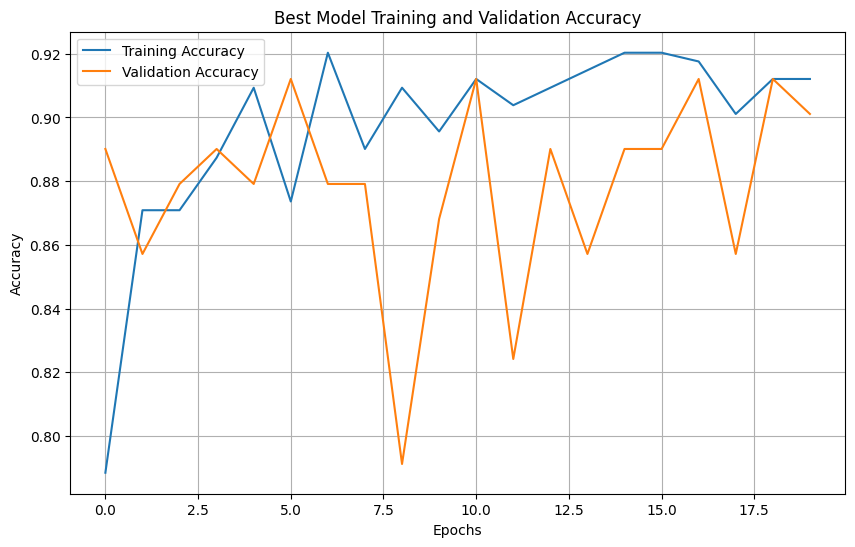

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_result["history"]["accuracy"], label="Training Accuracy")
plt.plot(best_result["history"]["val_accuracy"], label="Validation Accuracy")
plt.title("Best Model Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ray.shutdown()